Example:

$X_1 = 1 ; X_2 = 2 ; X_3 = 3$

$W_{11} = 0.1 ; W_{12} = 0.5; W_{13} = 0.1$

$f = sigmoid$

This algorithm was created by Gatys et al. (2015) (https://arxiv.org/abs/1508.06576)

In [1]:
import scipy.io
import scipy.misc
import numpy as np
import matplotlib.pyplot as plt

Set hyperparameter:
(Both content image and style image should be of type JPG)

In [2]:
#name of content and style images. 
content_image_name = 'lenna'
style_image_name = 'cartoon'

# set noise ratio for the initialization of the generated image
noise_ratio = 0.6


#content layer used to calculate content cost
content_layer = 'conv5_2'

#style layers used to calculate style cost
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']  
style_weights = [0.2, 0.2, 0.2, 0.2, 0.2]
try:
    assert len(style_layers) == len(style_weights)
except:
    print('Error: style_layers and style_weights must have same size')
    
#Neural network's hyper parameters
num_iterations = 500
learning_rate = 2.0

/home/kassaad/.virtualenvs/tensorlow/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kassaad/.virtualenvs/tensorlow/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


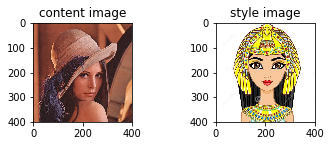

In [3]:
# content_image = scipy.misc.imread("data/lenna.jpg")
# style_image = scipy.misc.imread("data/cartoon2.jpg")
content_image = scipy.misc.imread("data/content/"+content_image_name+".jpg")
style_image = scipy.misc.imread("data/style/"+style_image_name+".jpg")

#common mean between the two images (will be used for normalisation)
common_mean = (np.mean(content_image, axis=(0, 1)) +np.mean(style_image, axis=(0, 1)))/2

try: 
    assert content_image.shape == style_image.shape
    image_width = content_image.shape[1]
    image_height = content_image.shape[0]
    nb_channels = content_image.shape[2]

    plt.subplot(2, 2, 1)
    plt.imshow(content_image)
    plt.title('content image')
    plt.subplot(2, 2, 2)
    plt.imshow(style_image)
    plt.title('style image')
except:
    print("Error: content image and style image must have same shape")

In [4]:
import tensorflow as tf

In [5]:
#Import a pre trained model: vgg
def load_vgg_model(path, image_width, image_height, nb_channels):
    """
    Returns a model for the purpose of 'painting' the picture.
    Takes only the convolution layer weights and wrap using the TensorFlow
    Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
    the paper indicates that using AveragePooling yields better results.
    The last few fully connected layers are not used.
    Here is the detailed configuration of the VGG model:
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is avgpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is avgpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is avgpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is avgpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is avgpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """

    IMAGE_WIDTH = image_width
    IMAGE_HEIGHT = image_height
    COLOR_CHANNELS = nb_channels
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        W = vgg_layers[0][layer][0][0][2][0][0]
        b = vgg_layers[0][layer][0][0][2][0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0] #vgg_layers[0][layer][0][0][-2]
#         print(vgg_layers[0][layer][0][0][2][0][0])
#         print(vgg_layers[0][layer][0][0][0][0][1])
        assert layer_name == expected_layer_name
        return W, b

    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(
            prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    return graph

In [6]:
model = load_vgg_model("pretrained_model/imagenet-vgg-verydeep-19.mat", image_width, image_height, nb_channels)

In [7]:
print(model)

{'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 400, 400, 64) dtype=float32>, 'conv5_4': <tf.Tensor 'Relu_15:0' shape=(1, 25, 25, 512) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 100, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 100, 100, 256) dtype=float32>, 'conv5_3': <tf.Tensor 'Relu_14:0' shape=(1, 25, 25, 512) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 100, 100, 256) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 200, 200, 128) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 100, 100, 256) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shape=(1, 50, 50, 512) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 200, 200, 64) dtype=float32>, 'conv5_2': <tf.Tensor 'Relu_13:0' shape=(1, 25, 25, 512) dtype=float32>, 'conv4_3': <tf.Tensor 'Relu_10:0' shape=(1, 50, 50, 512) dtype=float32>, 'input': <tf.Variable 'Variable:0' shape=(1, 400, 400, 3) dtype=float32_ref>, 'conv4_4': <tf.Tensor 'Relu_11:0' shape=(

Next, you can find functions that are needed to calculate the cost of the neural style transfer

In [8]:
def content_cost(C, G):
    """
    C: tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    G: tensor of dimension (1, n_H, n_W, n_G), hidden layer activations representing content of the image G
    Returns: cost between the content image and the generating image.
    """
    
    # Retrieve dimensions
    m, n_H, n_W, n_C = G.get_shape().as_list()
    
    # Reshape a_C and a_G
    C = tf.reshape(C, [m, n_H*n_W, n_C])
    G = tf.reshape(G, [m, n_H*n_W, n_C])
    
    # Calculate the cost
    J_content = tf.reduce_sum(tf.square(tf.subtract(C, G)))/(4*n_H*n_W*n_C)
    return J_content
    
def style_cost(S, G):
    """
    S: tensor of dimension (1, n_H, n_W, n_S), hidden layer activations representing content of the image S 
    G: tensor of dimension (1, n_H, n_W, n_G), hidden layer activations representing content of the image G
    Returns: cost between the style image and the generating image.
    """
    m, n_H, n_W, n_C = G.get_shape().as_list()
    # Reshape the images to have them of shape (n_C, n_H*n_W)
    S = tf.reshape(S, [n_H*n_W, n_C])
    G = tf.reshape(G, [n_H*n_W, n_C])

    # Gram_matrices for both images S and G
    GS = gram_matrix(tf.transpose(S))
    GG = gram_matrix(tf.transpose(G))

    # Calculate the cost
    J_style = tf.reduce_sum(tf.square(tf.subtract(GS, GG)))/(4*((n_H*n_W)**2)*(n_C**2))
    return J_style
    
def gram_matrix(A):
    """
    A: matrix of shape (n, m)
    Returns: Gram matrix of A, of shape (n, n)
    """
    GA = tf.matmul(A,tf.transpose(A))
    return GA

def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    J_content: content cost
    J_style: style cost
    alpha: hyperparameter weighting the importance of the content cost
    beta: hyperparameter weighting the importance of the style cost
    Returns: total cost
    """
    J = alpha*J_content+beta*J_style
    return J

In [9]:
#reshape the content and teh style images
content_image = content_image.reshape(1,content_image.shape[0],content_image.shape[1],content_image.shape[2])
style_image = style_image.reshape(1,style_image.shape[0],style_image.shape[1],style_image.shape[2])


#normalize the content and the style images
# common_mean = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))
common_mean = common_mean.reshape((1,1,1,3))
content_image = content_image - common_mean
style_image = style_image - common_mean

In [10]:
#generate noise image
noise_image = np.random.uniform(-20, 20, (content_image.shape)).astype('float32')
    
#Set the input_image to be a weighted average of the content_image and a noise_image
input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)

In [11]:
sess = tf.InteractiveSession()

#compute content cost
sess.run(model['input'].assign(content_image))

out = model[content_layer]
a_C = sess.run(out)
J_content = content_cost(a_C, out)


#compute style cost 
sess.run(model['input'].assign(style_image))

J_style_layer = []
for i in range(len(style_layers)):
    out = model[style_layers[i]]
    a_S = sess.run(out)
    J_style_layer.append(style_cost(a_S, out) * style_weights[i])

J_style = np.sum(J_style_layer)

In [12]:
#compute total cost
cost = total_cost(J_content, J_style, alpha = 0.2, beta = 0.8)

optimizer = tf.train.AdamOptimizer(learning_rate)

train_step = optimizer.minimize(cost)

In [13]:
#compute learning procedure
sess.run(tf.global_variables_initializer())

sess.run(model['input'].assign(input_image))

for i in range(num_iterations):
    sess.run(train_step)
    generated_image = sess.run(model['input'])

    if i%50 == 0:
        Jt, Jc, Js = sess.run([cost, J_content, J_style])
        print("Iteration " + str(i) + " :")
        print("total cost = " + str(Jt))
        print("content cost = " + str(Jc))
        print("style cost = " + str(Js))
Jt, Jc, Js = sess.run([cost, J_content, J_style])
print("Iteration " + str(i) + " :")
print("total cost = " + str(Jt))
print("content cost = " + str(Jc))
print("style cost = " + str(Js))

Iteration 0 :
total cost = 659517400.0
content cost = 21.589611
style cost = 824396740.0
Iteration 50 :
total cost = 76167990.0
content cost = 42.98688
style cost = 95209976.0
Iteration 100 :
total cost = 43422184.0
content cost = 46.56082
style cost = 54277720.0
Iteration 150 :
total cost = 31528170.0
content cost = 48.812305
style cost = 39410200.0
Iteration 200 :
total cost = 25170672.0
content cost = 50.51045
style cost = 31463328.0
Iteration 250 :
total cost = 21206156.0
content cost = 51.426025
style cost = 26507682.0
Iteration 300 :
total cost = 18480908.0
content cost = 52.066658
style cost = 23101122.0
Iteration 350 :
total cost = 16494771.0
content cost = 52.696514
style cost = 20618450.0
Iteration 400 :
total cost = 14931808.0
content cost = 53.344032
style cost = 18664746.0
Iteration 450 :
total cost = 13673595.0
content cost = 53.88095
style cost = 17091980.0
Iteration 499 :
total cost = 12612166.0
content cost = 54.482605
style cost = 15765194.0


Text(0.5,1,'generated image')

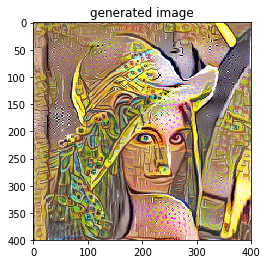

In [14]:
generated_image = generated_image + common_mean
generated_image = np.clip(generated_image[0], 0, 255).astype('uint8')
plt.imshow(generated_image)
plt.title('generated image')

In [15]:
import scipy.misc
scipy.misc.imsave('./data/generated/generated_'+content_image_name+'_'+style_image_name+'2.jpg', generated_image)

/home/kassaad/.virtualenvs/tensorlow/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  
